In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random
from tqdm import tqdm
import json
#data procedding
from sklearn.model_selection import train_test_split
#transformers
from transformers import AlbertTokenizer
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
#torch
from keras.utils import np_utils
import torch
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#set seed for reproducibility
seed=321
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
data = pd.read_json('~/environment/data/sample_1000000_2005_2018_cleaned.json')

In [4]:
data.head(1)

,index,text,stars,cleaned_text
1105058,2344352,Excellent food and customer service! My mom fo...,5,Excellent food and customer service ! My mom f...


In [5]:
data.stars.value_counts()

5    426404
4    266102
3    121561
1    102135
2     83798
Name: stars, dtype: int64

In [6]:
data['stars_reduce'] = data['stars']-1
dummy_y = np_utils.to_categorical(data.stars_reduce)
dummy_y.shape

(1000000, 5)

In [7]:
X_train, X_val,Y_train, Y_val = train_test_split(data.cleaned_text, dummy_y, test_size=0.2, 
                                                 stratify=dummy_y, random_state = seed)

In [8]:
MAX_LEN=512
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

In [33]:
def tokenize_albert(data,max_len=MAX_LEN) :
    input_ids = []
    labels = []
    
    for sent in data:
        encoded = tokenizer.encode(
            text=sent,
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN,
            padding=False
        )
        input_ids.append(encoded)
    return input_ids

In [34]:
train_ids = tokenize_albert(X_train, MAX_LEN)
val_ids = tokenize_albert(X_val, MAX_LEN)

In [35]:
#sort by length
train_samples = sorted(zip(train_ids, Y_train), key=lambda x: len(x[0]))
val_samples = sorted(zip(val_ids, Y_val), key=lambda x: len(x[0]))

In [36]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 512


In [37]:
def select_batches(samples, batch_size):
    batch_ordered_sentences = []
    batch_ordered_labels = []
    text_data = samples.copy()
    while len(text_data) > 0:
        to_take = min(batch_size, len(text_data))
        select = random.randint(0, len(text_data) - to_take)
        batch = text_data[select:(select + to_take)]
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])
        del text_data[select:select + to_take]
    # print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))
    return batch_ordered_sentences, batch_ordered_labels

In [38]:
def add_padding(batch_ordered_sentences, batch_ordered_labels):
    py_inputs = []
    py_attn_masks = []
    py_labels = []
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):
        batch_padded_inputs = []
        batch_attn_masks = []

        max_size = max([len(sen) for sen in batch_inputs])
        for sen in batch_inputs:
            num_pads = max_size - len(sen)
            padded_input = sen + [tokenizer.pad_token_id]*num_pads
            attn_mask = [1] * len(sen) + [0] * num_pads
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    return py_inputs,py_attn_masks,py_labels

In [39]:
def flat_accuracy(preds, labels):
    pred = np.argmax(preds, axis=1)+1
    label = np.argmax(labels, axis=1)+1
    # print('preds_flat ', pred)
    # print('labels_flat ', label)
    return np.sum(pred == label) / len(label)

In [11]:
config = AutoConfig.from_pretrained(pretrained_model_name_or_path='albert-base-v2',num_labels=5)
print('Config type:', str(type(config)), '\n')

Config type: <class 'transformers.models.albert.configuration_albert.AlbertConfig'> 



In [12]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='albert-base-v2',config=config)
print('\nModel type:', str(type(model)))

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho


Model type: <class 'transformers.models.albert.modeling_albert.AlbertForSequenceClassification'>


In [27]:
print('\nLoading model to GPU...')
device = torch.device('cuda')
print('  GPU:', torch.cuda.get_device_name(0))
desc = model.to(device)
print('    DONE.')


Loading model to GPU...
  GPU: Tesla V100-PCIE-16GB
    DONE.


In [40]:
BatchSize=8
Epochs=2
TotalSteps = len(train_ids) * Epochs
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = TotalSteps)

In [41]:
def model_train(model, epochs, batch_size, train_data, val_data):
    # store evaluation metrics
    training_stats = []
    total_t0 = time.time()

    for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        train_sentences, train_labels = select_batches(train_data, batch_size)
        train_input_ids, train_attention_masks, train_type_ids = add_padding(train_sentences, train_labels)

        
        print('Training on {:,} batches...'.format(len(train_input_ids)))
        t0 = time.time()
        total_train_accuracy = 0
        total_train_loss = 0
        model.train()
        for step in tqdm(range(0, len(train_input_ids))):
            b_input_ids = train_input_ids[step].to(device)
            b_input_mask = train_attention_masks[step].to(device)
            b_labels = train_type_ids[step].to(device)
            model.zero_grad()
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           labels=b_labels,
                           return_dict = True)
            loss = result.loss
            total_train_loss += loss.item()
            logits = result.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # print('logits ', logits)
            # print('label_ids ', label_ids)
            total_train_accuracy += flat_accuracy(logits, label_ids)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_input_ids)
        avg_train_accuracy = total_train_accuracy / len(train_input_ids)
        training_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
        print("")
        print("  Average training loss: {0:.4f}".format(avg_train_loss))
        print("  Average training accuracy: {0:.4f}".format(avg_train_accuracy))
        print("  Training epcoh {} took: {:}".format(epoch_i + 1, training_time))
    # ========================================
    #               Validation
    # ========================================
        val_sentences, val_labels = select_batches(val_data, batch_size)
        val_input_ids, val_attention_masks, val_type_ids = add_padding(val_sentences, val_labels)
        print('Validating on {:,} batches...'.format(len(val_input_ids)))
        t0 = time.time()
        total_val_accuracy = 0
        total_val_loss = 0
        model.eval()
        for step in tqdm(range(0, len(val_input_ids))):
            b_input_ids = val_input_ids[step].to(device)
            b_input_mask = val_attention_masks[step].to(device)
            b_labels = val_type_ids[step].to(device)
            with torch.no_grad():  
                val_result = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask, 
                                       labels=b_labels)
            logits = val_result.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            loss = val_result.loss
            total_val_loss += loss.item()
            total_val_accuracy += flat_accuracy(logits, label_ids)
        avg_val_accuracy = total_val_accuracy / len(val_input_ids)
        avg_val_loss = total_val_loss / len(val_input_ids)
        val_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
        print("")
        print("  Average validation loss: {0:.4f}".format(avg_val_loss))
        print("  Average validation accuracy: {0:.4f}".format(avg_val_accuracy))
        print("  Validation epcoh {} took: {:}".format(epoch_i + 1, val_time))
        torch.save(model.state_dict(), '/home/ubuntu/environment/model/albert_512_2005_2018_{}'.format(epoch_i + 1))
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Accuracy':avg_train_accuracy,
                'Training Time': training_time,
                'Validation Loss':avg_val_loss,
                'Validation Accuracy':avg_val_accuracy,
                'Validation Time': val_time,
            }
        )
    print("")
    print("Training complete!")
    total_time = str(datetime.timedelta(seconds = int(round(time.time() - total_t0))))
    print("Total training took: {:}".format(total_time))
    return training_stats

In [26]:
history_albert = model_train(model, Epochs, BatchSize, train_samples, val_samples)


======== Epoch 1 / 2 ========
Training on 100,000 batches...


100%|█████████████████████████████████| 100000/100000 [2:29:31<00:00, 11.15it/s]



  Average training loss: 0.2528
  Average training accuracy: 0.7024
  Training epcoh 1 took: 2:29:32
Validating on 25,000 batches...


100%|█████████████████████████████████████| 25000/25000 [11:26<00:00, 36.41it/s]



  Average validation loss: 0.2566
  Average validation accuracy: 0.6930
  Validation epcoh 1 took: 0:11:27

======== Epoch 2 / 2 ========
Training on 100,000 batches...


100%|█████████████████████████████████| 100000/100000 [2:30:37<00:00, 11.06it/s]



  Average training loss: 0.2452
  Average training accuracy: 0.7142
  Training epcoh 2 took: 2:30:38
Validating on 25,000 batches...


100%|█████████████████████████████████████| 25000/25000 [11:26<00:00, 36.41it/s]



  Average validation loss: 0.2612
  Average validation accuracy: 0.6966
  Validation epcoh 2 took: 0:11:27

Training complete!
Total training took: 5:24:08


In [ ]:
#torch.save(model.state_dict(), '/home/ubuntu/environment/model/albert_512_2005_2018')

In [43]:
with open("/home/ubuntu/environment/performance/albert_512_history_2.json", 'w') as f:
    json.dump(history_albert, f, indent=2) 

In [44]:
history = pd.DataFrame.from_records(history_albert)
history

,epoch,Training Loss,Training Accuracy,Training Time,Validation Loss,Validation Accuracy,Validation Time
0,1,0.241503,0.720326,2:29:29,0.260697,0.69329,0:11:27
1,2,0.236515,0.728069,2:30:54,0.260497,0.69438,0:11:28


Text(0.5, 1.0, 'Accuracy')

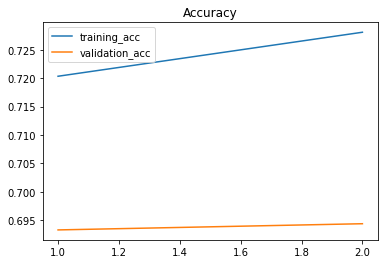

In [45]:
#plot accuracy
# plt.figure(figsize=(15, 7))
plt.plot(range(1, Epochs+1), history['Training Accuracy'])
plt.plot(range(1, Epochs+1), history['Validation Accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

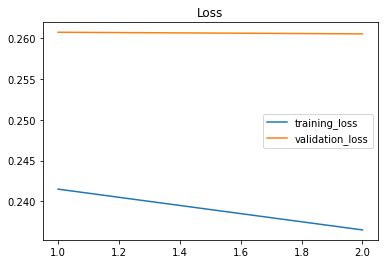

In [46]:
#plot loss
#plt.figure(figsize=(15, 7))
plt.plot(range(1, Epochs+1), history['Training Loss'])
plt.plot(range(1, Epochs+1), history['Validation Loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [13]:
model_loaded = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='albert-base-v2',config=config)
model_loaded.load_state_dict(torch.load('/home/ubuntu/environment/model/albert_512_2005_2018_2'))
device = torch.device('cuda')
desc = model_loaded.to(device)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [14]:
data_test= pd.read_json('~/environment/data/restaurant_review_2019_cleaned.json')

In [15]:
test_star_reduce = data_test['stars']-1
dummy_test_y = np_utils.to_categorical(test_star_reduce)

In [16]:
MAX_LEN=512
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
BatchSize=8

In [17]:
def fixed_padding(tokenizer, train_text, train_labels, batch_size, max_len):
    batches_input_ids = []
    batches_attention_masks = []
    batches_labels = []
    for i in tqdm(range(0, len(train_text), batch_size)):
        encoded_dict = tokenizer.batch_encode_plus(
            train_text[i:i+batch_size], # Batch of sentences to encode.
            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
            max_length = max_len,           # Pad & truncate all sentences.
            padding = 'max_length',     # Pad all to the `max_length` parameter.
            truncation = True,
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors = 'pt',     # Return pytorch tensors.
        )
        batches_input_ids.append(encoded_dict['input_ids'])
        batches_attention_masks.append(encoded_dict['attention_mask'])
        batches_labels.append(torch.tensor(train_labels[i:i+batch_size]))
    return batches_input_ids,batches_attention_masks,batches_labels

In [18]:
train_input_ids, train_attention_masks, train_type_ids = fixed_padding(tokenizer, 
                                                                    X_train,
                                                                    Y_train,
                                                                    BatchSize, MAX_LEN)

100%|██████████████████████████████████| 100000/100000 [14:39<00:00, 113.72it/s]


In [19]:
val_input_ids, val_attention_masks, val_type_ids = fixed_padding(tokenizer, 
                                                                    X_val,
                                                                    Y_val,
                                                                    BatchSize, MAX_LEN)

100%|████████████████████████████████████| 25000/25000 [03:46<00:00, 110.24it/s]


In [20]:
test_input_ids, test_attention_masks, test_type_ids = fixed_padding(tokenizer, 
                                                                    data_test.cleaned_text,
                                                                    dummy_test_y,
                                                                    BatchSize, MAX_LEN)

100%|████████████████████████████████████| 65575/65575 [09:05<00:00, 120.12it/s]


In [21]:
def model_predict(model, batch_size, test_input_ids, test_attention_masks, test_type_ids):
    t0 = time.time()
    predictions , true_labels = [], []
    
    print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
    model.eval()
    for step in tqdm(range(0, len(test_input_ids))):
        b_input_ids = test_input_ids[step].to(device)
        b_input_mask = test_attention_masks[step].to(device)
        b_labels = test_type_ids[step].to(device)
        with torch.no_grad():  
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    test_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
    print("Total testing took: {:}".format(test_time))
    return predictions, true_labels

In [22]:
train_evals, train_stars = model_predict(model_loaded, BatchSize, train_input_ids, train_attention_masks, train_type_ids)

Predicting labels for 100,000 test sentences...


100%|█████████████████████████████████| 100000/100000 [2:41:01<00:00, 10.35it/s]

Total testing took: 2:41:02


In [23]:
train_eval = np.argmax(np.concatenate(train_evals, axis=0), axis = 1)+1
train_star = np.argmax(np.concatenate(train_stars, axis=0), axis = 1)+1

In [24]:
confusion_matrix(train_star, train_eval)

array([[ 65401,  13895,   1448,    282,    682],
       [ 13546,  39028,  12463,   1283,    718],
       [  2545,  14093,  56239,  20937,   3435],
       [   690,   1254,  15260, 122879,  72799],
       [   740,    301,   1525,  39047, 299510]])

In [25]:
print(classification_report(train_star, train_eval, digits = 4))

              precision    recall  f1-score   support

           1     0.7887    0.8004    0.7945     81708
           2     0.5692    0.5822    0.5756     67038
           3     0.6469    0.5783    0.6107     97249
           4     0.6663    0.5772    0.6186    212882
           5     0.7942    0.8780    0.8340    341123

    accuracy                         0.7288    800000
   macro avg     0.6930    0.6832    0.6867    800000
weighted avg     0.7228    0.7288    0.7238    800000



In [26]:
val_evals, val_stars = model_predict(model_loaded, BatchSize, val_input_ids, val_attention_masks, val_type_ids)

Predicting labels for 25,000 test sentences...


100%|█████████████████████████████████████| 25000/25000 [40:15<00:00, 10.35it/s]

Total testing took: 0:40:16


In [27]:
val_eval = np.argmax(np.concatenate(val_evals, axis=0), axis = 1)+1
val_star = np.argmax(np.concatenate(val_stars, axis=0), axis = 1)+1

In [28]:
confusion_matrix(val_star, val_eval)

array([[15802,  3777,   481,   122,   245],
       [ 3758,  8803,  3510,   453,   236],
       [  760,  3936, 12926,  5702,   988],
       [  244,   407,  4485, 28474, 19610],
       [  276,   121,   533, 11043, 73308]])

In [29]:
print(classification_report(val_star, val_eval, digits = 4))

              precision    recall  f1-score   support

           1     0.7583    0.7736    0.7658     20427
           2     0.5165    0.5252    0.5208     16760
           3     0.5893    0.5317    0.5590     24312
           4     0.6218    0.5350    0.5752     53220
           5     0.7767    0.8596    0.8160     85281

    accuracy                         0.6966    200000
   macro avg     0.6525    0.6450    0.6474    200000
weighted avg     0.6890    0.6966    0.6908    200000



In [17]:
preds, stars = model_predict(model_loaded, BatchSize, test_input_ids, test_attention_masks, test_type_ids)

Predicting labels for 65,575 test sentences...


100%|███████████████████████████████████| 65575/65575 [1:45:27<00:00, 10.36it/s]

Total testing took: 1:45:28


In [18]:
pred = np.argmax(np.concatenate(preds, axis=0), axis = 1)+1
star = np.argmax(np.concatenate(stars, axis=0), axis = 1)+1

In [19]:
confusion_matrix(data_test['stars'], pred)

array([[ 55571,   9033,   2513,    457,    830],
       [ 11342,  18713,   8503,    966,    429],
       [  2685,   8707,  28843,   9119,   1294],
       [   527,    506,  11087,  60387,  28809],
       [   632,    117,   1604,  41062, 220857]])

In [20]:
print(classification_report(data_test['stars'], pred, digits=4))

              precision    recall  f1-score   support

           1     0.7854    0.8124    0.7987     68404
           2     0.5047    0.4684    0.4859     39953
           3     0.5489    0.5695    0.5590     50648
           4     0.5392    0.5960    0.5662    101316
           5     0.8757    0.8357    0.8552    264272

    accuracy                         0.7327    524593
   macro avg     0.6508    0.6564    0.6530    524593
weighted avg     0.7391    0.7327    0.7353    524593



In [21]:
data_test['stars_albert_512'] = pred

In [24]:
data_test.to_json('~/environment/data/restaurant_review_2019_cleaned_albert_512_prediction.json')

In [ ]:
'''
padded_lengths = []

for batch in train_input_ids:
    for s in batch:
        padded_lengths.append(len(s))
smart_token_count = np.sum(padded_lengths)

fixed_token_count = len(X_train) * MAX_LEN
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))
'''